In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install underthesea -qq
!pip install transformers -qq
!pip install tokenizer -qq
!pip install openpyxl -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 2.4 MB/s eta 0:00:00


# 1. Load data and train test split

Data 27/7

In [ ]:
!gdown 10i3J7xkYshApkpLlKKMC_Nw3PqI9fJ2g

Downloading...
From: https://drive.google.com/uc?id=10i3J7xkYshApkpLlKKMC_Nw3PqI9fJ2g
To: /content/data2707.csv
100% 4.36M/4.36M [00:00<00:00, 251MB/s]


Data 2/8

In [ ]:
!gdown 180f4xE60i8YaAaUPrixnvJJOvSXQW9aX

Downloading...
From: https://drive.google.com/uc?id=180f4xE60i8YaAaUPrixnvJJOvSXQW9aX
To: /content/data0208.csv
100% 12.8M/12.8M [00:00<00:00, 48.1MB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
import numpy as np
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import openpyxl
from sklearn.metrics import confusion_matrix,classification_report
#for text cleaning
import string
import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
import underthesea
from underthesea import word_tokenize

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
import re
from sklearn import preprocessing
def preprocess_text(text):
    # Check if text is a list
    if isinstance(text, list):
        # Join the list of words into a single string
        text = ' '.join(text)

    # Remove icons
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    return ' '.join(simple_preprocess(text))

In [ ]:
import os

def load_and_preprocess_data(data_file, encoding=None):
    # Load the original dataframe
    _, file_extension = os.path.splitext(data_file)
    # Load the original dataframe
    if file_extension == '.csv':
        df = pd.read_csv(data_file, encoding=encoding)
    elif file_extension in ['.xls', '.xlsx']:
        df = pd.read_excel(data_file)
    else:
        raise ValueError(f'Unsupported file format: {file_extension}')
    df['LABEL'] = df['LABEL'].str.strip().str.title()
    # Split the data into training, validation, and testing sets
    train, temp = train_test_split(df, test_size=0.3, random_state=42)
    dev, test = train_test_split(temp, test_size=0.5, random_state=42)

    # Preprocess the text
    train['Q1'] = train['Q1'].astype(str).apply(preprocess_text)
    dev['Q1'] = dev['Q1'].astype(str).apply(preprocess_text)
    test['Q1'] = test['Q1'].astype(str).apply(preprocess_text)

    # Create boolean masks to select rows where free_text is not equal to an empty string
    mask_train = train['Q1'] != ""
    mask_dev = dev['Q1'] != ""
    mask_test = test['Q1'] != ""

    # Use the boolean masks to select the rows of interest
    train = train[mask_train]
    dev = dev[mask_dev]
    test = test[mask_test]

    # Convert free_text column to string
    train['Q1'] = train['Q1'].astype(str)
    X_train = train['Q1']
    y_train = train["LABEL"]

    dev['Q1'] = dev['Q1'].astype(str)
    X_valid = dev['Q1']
    y_valid = dev['LABEL']

    test['Q1'] = test['Q1'].astype(str)
    X_test = test['Q1']
    y_test = test['LABEL']

    return df, X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
df, X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_preprocess_data("/content/Data1608.xlsx")
df

,LABEL,Q1
0,Dị Ứng - Miễn Dịch Lâm Sàng,"['bé', 'trai', 'nhà ngứa', 'ở', 'vùng', 'cổ', ..."
1,Dị Ứng - Miễn Dịch Lâm Sàng,"['mẹ', 'ngứa', 'khắp', 'người', 'mẹ', 'ở', 'qu..."
2,Dị Ứng - Miễn Dịch Lâm Sàng,"['dạo', 'nổi', 'ngứa hiệu', 'mua', 'ngứa', 'ti..."
3,Dị Ứng - Miễn Dịch Lâm Sàng,"['rượu', 'bia', 'tiêm', 'văcsin', 'covid', 'ho..."
4,Dị Ứng - Miễn Dịch Lâm Sàng,"['ờ', 'nha trang', 'xét nghiệm', 'máu', 'chẩn ..."
...,...,...
26338,Tdcn Hô Hấp,"['thở', 'ngủ', 'hít', 'sâu lưỡi', 'gà', 'rung ..."
26339,Tdcn Hô Hấp,"['kia', 'hen', 'phế quản', 'chữa', 'khỏi', 'cứ..."
26340,Tdcn Hô Hấp,"['thi thoảng', 'đau', 'tim', 'hít', 'đặc biệt'..."
26341,Tdcn Hô Hấp,"['ông', 'xã', 'nhà đờm', 'thở', 'tức', 'ngực',..."


In [ ]:
df, X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_preprocess_data("/content/data2707.csv", encoding = "utf-8")
df

,LABEL,Q1
0,Dị Ứng - Miễn Dịch Lâm Sàng,bé trai nhà ngứa ở vùng cổ mặt ngực thắt lưng ...
1,Dị Ứng - Miễn Dịch Lâm Sàng,mẹ ngứa khắp người mẹ ở quê thước bớt đưa mẹ h...
2,Dị Ứng - Miễn Dịch Lâm Sàng,dạo nổi ngứa hiệu mua ngứa tiếp tục trạng ngứa...
3,Dị Ứng - Miễn Dịch Lâm Sàng,rượu bia tiêm văcsin covid hoặc bia người xảy ...
4,Dị Ứng - Miễn Dịch Lâm Sàng,ờ nha trang xét nghiệm máu chẩn giun sán chó ở...
...,...,...
17790,Xương Khớp,67kg trở đau nhức lưng xuống tới bàn trái đau ...
17791,Xương Khớp,mẹ 84t đau lưng bhyt ở gò vấp chẩn teo đầu đốt...
17792,Xương Khớp,18 xưng ngón cái phần thịt phía dưới gây đau n...
17793,Xương Khớp,xuyên nhức dói hụt khớp gối khoa đúng


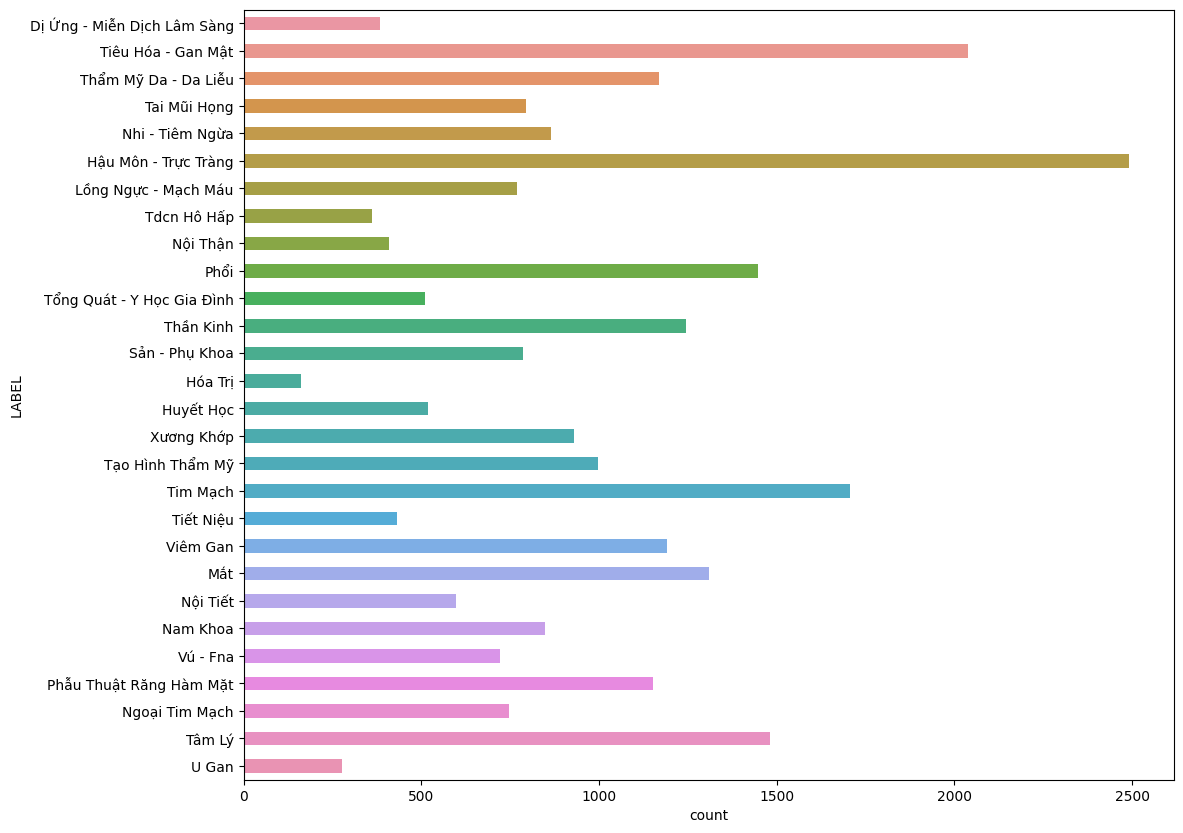

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(data=df, y='LABEL', width=0.5)
plt.show()

# 2. Feature extraction

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Encode labels with value between 0 and n_classes-1.
le = LabelEncoder()
y = df["LABEL"]
y = le.fit_transform(y)
Y_train = le.transform(y_train)
Y_valid = le.transform(y_valid)
Y_test = le.transform(y_test)

# Converts a class vector (integers) to binary class matrix.
y_train = to_categorical(Y_train)
y_valid = to_categorical(Y_valid)
y_test = to_categorical(Y_test)


y_train = np.asarray(y_train).astype('int32')
y_valid = np.asarray(y_valid).astype('int32')
y_test = np.asarray(y_test).astype('int32')

In [ ]:
y_count = df['LABEL'].nunique()
y_count

28

## Word2vec

In [ ]:
max_len = X_train.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 2479


In [ ]:
from transformers import AutoTokenizer
from tensorflow.keras.preprocessing import text, sequence

# Load the PhoBERT tokenizer
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Tokenize the text data using the PhoBERT tokenizer
X_train_tokenized = [phobert_tokenizer.tokenize(doc) for doc in X_train]
X_valid_tokenized = [phobert_tokenizer.tokenize(doc) for doc in X_valid]
X_test_tokenized = [phobert_tokenizer.tokenize(doc) for doc in X_test]
# Create a word-to-index mapping based on the tokenized text data
word_index = {}
index = 1
for doc in X_train_tokenized:
    for token in doc:
        if token not in word_index:
            word_index[token] = index
            index += 1

# Convert the tokenized text data to sequences of integer indices
# Convert the tokenized text data to sequences of integer indices, skipping OOV tokens
X_train_seq = [[word_index[token] for token in doc if token in word_index] for doc in X_train_tokenized]
X_valid_seq = [[word_index[token] for token in doc if token in word_index] for doc in X_valid_tokenized]
X_test_seq = [[word_index[token] for token in doc if token in word_index] for doc in X_test_tokenized]

# Pad the sequences to a fixed length
  # Set this to the desired maximum sequence length
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_valid_pad = sequence.pad_sequences(X_valid_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

# Print an example
print('text example:', X_train.iloc[0])
print('tokenized text:', X_train_tokenized[0])
print('sequence of indices(before padding):', X_train_seq[0])
print('sequence of indices(after padding):', X_train_pad[0])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


text example: cục hạch nhỏ cổ xet nghiêm wbc neu lym môn eos baso neu lym mono eos baso rbc hb hct mcv mch mchc rdw plt mpv tsh ultra centaur ferrtin hoi bac sy la voi ket qua tren toi co bi benh gi khong toi chan thanh cam on
tokenized text: ['cục', 'hạch', 'nhỏ', 'cổ', 'xe@@', 't', 'nghiêm', 'w@@', 'b@@', 'c', 'ne@@', 'u', 'ly@@', 'm', 'môn', 'e@@', 'os', 'bas@@', 'o', 'ne@@', 'u', 'ly@@', 'm', 'mono', 'e@@', 'os', 'bas@@', 'o', 'r@@', 'b@@', 'c', 'h@@', 'b', 'h@@', 'ct', 'mc@@', 'v', 'm@@', 'ch', 'm@@', 'ch@@', 'c', 'r@@', 'd@@', 'w', 'pl@@', 't', 'mp@@', 'v', 'ts@@', 'h', 'ul@@', 'tra', 'cen@@', 'ta@@', 'ur', 'f@@', 'err@@', 'tin', 'hoi', 'ba@@', 'c', 'sy', 'la', 'voi', 'ket', 'qua', 'tr@@', 'en', 'toi', 'co', 'bi', 'be@@', 'nh', 'gi', 'kh@@', 'ong', 'toi', 'chan', 'thanh', 'cam', 'on']
sequence of indices(before padding): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 11, 12, 13, 14, 20, 16, 17, 18, 19, 21, 9, 10, 22, 23, 22, 24, 25, 26, 27, 28, 27, 29, 10, 21

In [ ]:
import textwrap
text1 = X_train.iloc[9]
wrapped_text = textwrap.wrap(text1, width=50)
print('Text example:')
for line in wrapped_text:
    print(line)
text = X_train_tokenized[9]
text_str = ", ".join(text)
wrapped_text = textwrap.wrap(text_str, width=50)
print()
print('Tokenized text:')
for line in wrapped_text:
    print(line)

Text example:
chích ngữa vắc ngừa ung thư cổ tử cung chích kiểm
tra việc kiểm tra tự tới chích sẽ kiểm tra chích
ngừa vắc quy trìn chích ngừa

Tokenized text:
chích, ng@@, ữa, v@@, ắc, ngừa, ung, thư, cổ, tử,
cung, chích, kiểm, tra, việc, kiểm, tra, tự, tới,
chích, sẽ, kiểm, tra, chích, ngừa, v@@, ắc, quy,
tr@@, ìn, chích, ngừa


In [ ]:
# Convert tokenized text to list of sentences (words)
#sentences = [row.split() for row in df['Q1'].astype(str).tolist()]

from gensim.models import Word2Vec

# Train Word2Vec model

w2vec_model = Word2Vec(X_train_tokenized, vector_size=300, window=35, min_count=10, workers=8)

# Save model
w2vec_model.save('word2vec_model.bin')

# Load your trained model
w2vec_model = Word2Vec.load('/content/word2vec_model.bin')

# Create a dictionary to hold your word embeddings
embedding_vectors = {}

for word in w2vec_model.wv.key_to_index:
    embedding_vectors[word] = w2vec_model.wv[word]

print(f"Size of vocabulary in Word2Vec: {len(embedding_vectors)}")

Size of vocabulary in Word2Vec: 3188


In [ ]:
w2vec_model = Word2Vec.load('/content/word2vec_model.bin')
term = "đẹp"
similar_words = w2vec_model.wv.most_similar(term, topn=5)

# Print the result
print(f'Top 5 words similar with {term}:')
for word, similarity in similar_words:
    print(f'{word}: {similarity:.2f}')

Top 5 words similar with đẹp:
mĩ: 0.82
thẩm: 0.80
viễn: 0.78
trông: 0.77
gương: 0.75


Setup for ML

In [ ]:
from transformers import AutoTokenizer

# Tokenize the text data using the PhoBERT tokenizer
tokenized_text = [phobert_tokenizer.tokenize(doc) for doc in X_train]
# Train the Word2Vec model
#w2v_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=35, min_count=10, workers=8)
def document_vector(doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in w2vec_model.wv.key_to_index]

    # Check if the doc array is empty
    if len(doc) == 0:
        # Return a zero vector
        return np.zeros(w2vec_model.vector_size)
    else:
        # Compute the mean of the word vectors
        return np.mean(w2vec_model.wv[doc], axis=0)

X_train_w2v = np.array([document_vector(doc) for doc in tokenized_text])
X_valid_w2v = np.array([document_vector(phobert_tokenizer.tokenize(doc)) for doc in X_valid])
X_test_w2v = np.array([document_vector(phobert_tokenizer.tokenize(doc)) for doc in X_test])

Setup for DL

In [ ]:
#initialize the embedding_matrix with zeros
emb_dim = 300

vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['cen@@', 'err@@', 'nhiễu', 'ale@@', 'ìn']
3505 out of 6694 words were OOV.


## TF-IDF

In [ ]:
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenizer(text):
    return ViTokenizer.tokenize(text)

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from underthesea import word_tokenize, sent_tokenize
from sklearn.svm import SVC
from sklearn.metrics import classification_report
def tokenizer(text):
    return word_tokenize(text)
vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                             #stop_words=my_stopwords
                             )
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def custom_tokenizer(text):
    tokens = phobert_tokenizer.tokenize(text)
    words = phobert_tokenizer.convert_tokens_to_string(tokens).split()
    return words
vectorizer = TfidfVectorizer(
                            tokenizer=custom_tokenizer,
                            ngram_range=(1,1)
                             )
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Some TF-IDF inference

In [ ]:
# Print the unique labels in text form
unique_labels = le.classes_
print("Unique labels:")
for label in unique_labels:
    print(label)

Unique labels:
Dị Ứng - Miễn Dịch Lâm Sàng
Hậu Môn - Trực Tràng
Lồng Ngực - Mạch Máu
Mắt
Nam Khoa
Ngoại Tim Mạch
Nhi - Tiêm Ngừa
Nội Tiết
Phẫu Thuật Răng Hàm Mặt
Phổi
Sản - Phụ Khoa
Sức Khỏe
Tai Mũi Họng
Tdcn Hô Hấp
Thần Kinh
Thẩm Mỹ Da - Da Liễu
Tim Mạch
Tiêu Hóa - Gan Mật
Tiết Niệu
Tạo Hình Thẩm Mỹ
Tổng Quát - Y Học Gia Đình
Viêm Gan
Vú - Fna
Vấn Đề Khác
Xương Khớp


In [ ]:
import numpy as np

def print_top_weighted_words(label, n):
    label_encoded = le.transform([label])[0]
    X_train_tfidf_label = X_train_tfidf[Y_train == label_encoded]
    tfidf_means = np.mean(X_train_tfidf_label, axis=0)
    sorted_indices = np.argsort(tfidf_means)[:,::-1]
    feature_names = vectorizer.get_feature_names_out()

    print(f"Top {n} weighted words for label {label}:")
    for i in range(n):
        index = sorted_indices[0, i]
        print(f"{feature_names[index]}: {tfidf_means[0, index]}")

print_top_weighted_words("Tổng Quát - Y Học Gia Đình", 6)
#print_top_weighted_words("Tiết Niệu", 20)

Top 6 weighted words for label Tổng Quát - Y Học Gia Đình:
quát: 0.11343293771966333
tổng: 0.11092840748605431
xét: 0.04497636878490282
nghiệm: 0.04365665229666144
mẹ: 0.0400389698509576
khoa: 0.03555970796222304


In [ ]:
def print_word_rank(word, label):
    label_encoded = le.transform([label])[0] # Convert the label to its corresponding integer
    X_train_tfidf_label = X_train_tfidf[Y_train == label_encoded] # Use Y_train instead of y_train
    tfidf_means = np.mean(X_train_tfidf_label, axis=0)
    sorted_indices = np.argsort(tfidf_means)[:,::-1]
    feature_names = vectorizer.get_feature_names_out()
    word_index = np.where(feature_names == word)[0][0]
    word_rank = np.where(sorted_indices == word_index)[1][0] + 1
    print(f"Rank of '{word}' for label {label}: {word_rank}")

# Print the unique labels in text form
unique_labels = le.classes_
for label in unique_labels:
    print_word_rank("mẹ", label)

Rank of 'mẹ' for label Dị Ứng - Miễn Dịch Lâm Sàng: 65
Rank of 'mẹ' for label Hậu Môn - Trực Tràng: 256
Rank of 'mẹ' for label Lồng Ngực - Mạch Máu: 28
Rank of 'mẹ' for label Mắt: 40
Rank of 'mẹ' for label Nam Khoa: 1816
Rank of 'mẹ' for label Ngoại Tim Mạch: 16
Rank of 'mẹ' for label Nhi - Tiêm Ngừa: 32
Rank of 'mẹ' for label Nội Tiết: 45
Rank of 'mẹ' for label Phẫu Thuật Răng Hàm Mặt: 108
Rank of 'mẹ' for label Phổi: 6
Rank of 'mẹ' for label Sản - Phụ Khoa: 123
Rank of 'mẹ' for label Sức Khỏe: 4
Rank of 'mẹ' for label Tai Mũi Họng: 108
Rank of 'mẹ' for label Tdcn Hô Hấp: 46
Rank of 'mẹ' for label Thần Kinh: 4
Rank of 'mẹ' for label Thẩm Mỹ Da - Da Liễu: 55
Rank of 'mẹ' for label Tim Mạch: 6
Rank of 'mẹ' for label Tiêu Hóa - Gan Mật: 23
Rank of 'mẹ' for label Tiết Niệu: 15
Rank of 'mẹ' for label Tạo Hình Thẩm Mỹ: 213
Rank of 'mẹ' for label Tổng Quát - Y Học Gia Đình: 5
Rank of 'mẹ' for label Viêm Gan: 51
Rank of 'mẹ' for label Vú - Fna: 26
Rank of 'mẹ' for label Vấn Đề Khác: 11
Rank o

In [ ]:
def get_top_words(label, n):
    label_encoded = le.transform([label])[0] # Convert the label to its corresponding integer
    X_train_tfidf_label = X_train_tfidf[Y_train == label_encoded] # Use Y_train instead of y_train
    tfidf_means = np.mean(X_train_tfidf_label, axis=0)
    sorted_indices = np.argsort(tfidf_means)[:,::-1]
    feature_names = vectorizer.get_feature_names_out()

    top_words = []
    for i in range(n):
        index = sorted_indices[0, i]
        top_words.append(feature_names[index])
    return top_words

# Use the unique labels in text form
unique_labels = le.classes_
top_words = set(get_top_words(unique_labels[0], 20))
for label in unique_labels[1:]:
    label_top_words = set(get_top_words(label, 20))
    top_words.intersection_update(label_top_words)

top_30_common_words = list(top_words)[:30]
print(f"Top 30 words that are in the top 20 rankings of all classes: {top_30_common_words}")

Top 30 words that are in the top 20 rankings of all classes: []


#3. DL model

In [ ]:
from keras.optimizers import Adam

def build_model(rnn_layer, vocab_len, emb_dim, y_count, embedding_matrix, learning_rate):
    model = Sequential()
    model.add(Embedding(vocab_len, emb_dim, trainable=True, weights=[embedding_matrix]))
    model.add(rnn_layer)
    model.add(Dropout(0.9))
    model.add(Dense(y_count, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate) # You can set the learning rate value you want here
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

def train_model(model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, epochs, model_name):
    model_path = f"{folder_path}/{model_name}_best_model.h5"

    # Create the directory if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True)

    history = model.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), batch_size=batch_size, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history


folder_path = "/content/drive/MyDrive/saved_models"

In [ ]:
def plot_accuracy(history):
    epochs = len(history.history['accuracy'])
    plt.figure(figsize=(15, 7))
    plt.plot(range(epochs), history.history['accuracy'])
    plt.plot(range(epochs), history.history['val_accuracy'])
    plt.legend(['training_acc', 'validation_acc'])
    plt.title('Accuracy')
    plt.show()

In [ ]:

def evaluate_model(model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, le):
    # Evaluate the model
    train_results = model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=batch_size)
    test_results = model.evaluate(X_valid_pad, np.asarray(y_valid), verbose=0, batch_size=batch_size)
    print(f'Train accuracy: {train_results[1]*100:0.2f}')
    print(f'Test accuracy: {test_results[1]*100:0.2f}')

    # Get predictions for the test data
    y_pred = model.predict(X_valid_pad, batch_size=batch_size)

    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_valid_classes = np.argmax(y_valid, axis=1)

    # Inverse transform the class labels to get the original text labels
    y_pred_labels = le.inverse_transform(y_pred_classes)
    y_valid_labels = le.inverse_transform(y_valid_classes)

    # Print classification report with text labels
    print("Classification Report:")
    print(classification_report(y_valid_labels, y_pred_labels))

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

def check_wrong(real_values, predicts, le):
    predicts = np.argmax(predicts, axis=1)  # Convert probabilities to class labels
    wrong_indices = np.where(predicts != np.argmax(real_values, axis=1))[0]
    wrong_predictions = predicts[wrong_indices]

    for i in range(min(28, len(wrong_indices))):
        idx = wrong_indices[i]
        pred_class_label = le.inverse_transform([wrong_predictions[i]])[0]
        actual_class_label = le.inverse_transform([np.argmax(real_values[idx])])[0]
        print(f"Text: {X_test.iloc[wrong_indices[i]]}")
        print(f"Predicted: {pred_class_label} - Actual: {actual_class_label}\n")

In [ ]:
batch_size = 256
epochs  = 100
# Define embedding dimension
emb_dim = embedding_matrix.shape[1]

##RNN

In [ ]:
from keras.layers import SimpleRNN
rnn_model = build_model(SimpleRNN(128, return_sequences=False), vocab_len, emb_dim, y_count, embedding_matrix, learning_rate = 0.0005)

In [ ]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         2008200   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               54912     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 28)                3612      
                                                                 
Total params: 2,066,724
Trainable params: 2,066,724
Non-trainable params: 0
_________________________________________________________________


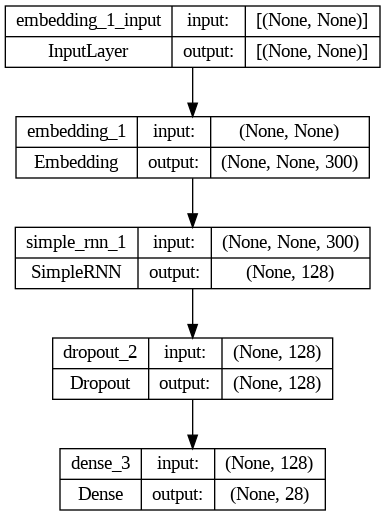

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(rnn_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train RNN model
model_name = "RNN1608"
rnn_history = train_model(rnn_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, epochs, model_name)

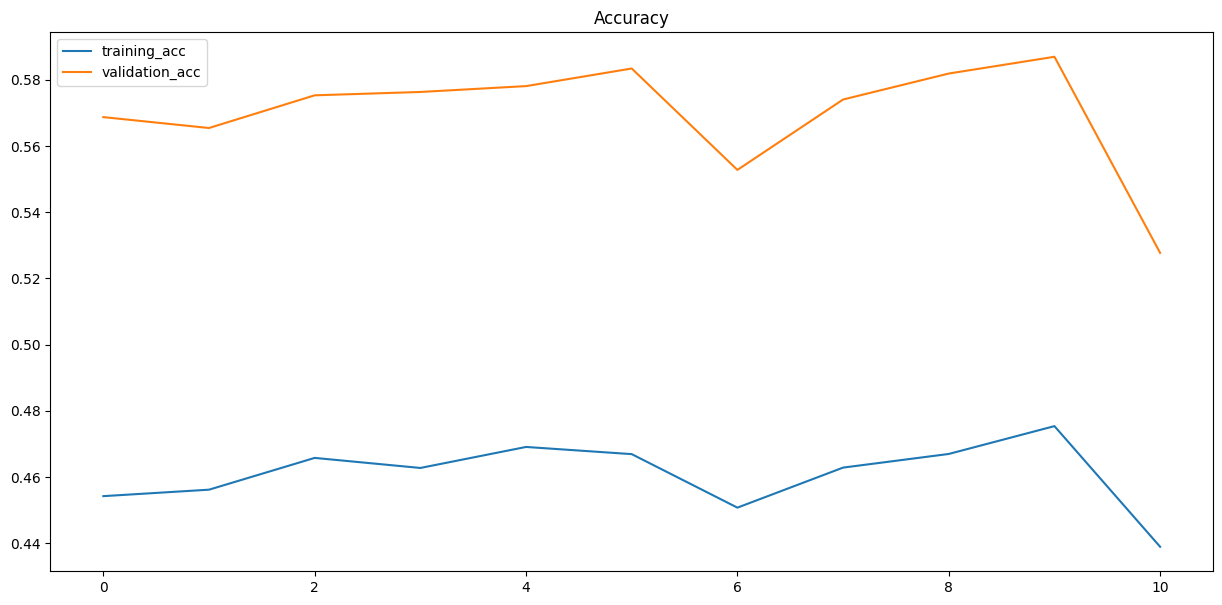

In [ ]:
plot_accuracy(rnn_history)

In [ ]:
from keras.models import load_model
model_name = "RNN1608"
best_model_path = f"{folder_path}/{model_name}_best_model.h5"
best_rnn_model = load_model(best_model_path)

evaluate_model(best_rnn_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, le)

Train accuracy: 61.75
Test accuracy: 58.69
8/8 [==============================] - 0s 19ms/step
Classification Report:
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.00      0.00      0.00        44
                  Huyết Học       0.57      0.07      0.13        55
                    Hóa Trị       0.00      0.00      0.00        24
       Hậu Môn - Trực Tràng       0.88      0.94      0.91       363
       Lồng Ngực - Mạch Máu       0.40      0.46      0.43       114
                        Mắt       0.73      0.90      0.81       199
                   Nam Khoa       0.49      0.67      0.57       134
             Ngoại Tim Mạch       0.60      0.03      0.05       116
            Nhi - Tiêm Ngừa       0.58      0.39      0.46       135
                   Nội Thận       0.62      0.38      0.47        56
                   Nội Tiết       0.40      0.20      0.26        92
    Phẫu Thuật Răng Hàm Mặt       0.58      0.90     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_probs = best_rnn_model.predict(X_test_pad)

# Check wrong predictions for RNN model
check_wrong(y_test, y_pred_probs, le)

124/124 [==============================] - 2s 12ms/step
Text: tổ chức đám cưới đám cưới luôn xét nghiệm những chuẩn những viên sắt mang thai
Predicted: Nội Tiết - Actual: Sản - Phụ Khoa

Text: học dịch vụ xét nghiệm gen mang thai giá xét nghiệm
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Sản - Phụ Khoa

Text: mọi người bố đường mật di căn gan đa bố truyền hóa chất nhất bsi bảo men gan tăng men gan tăng quá cao truyền mọi người hạ men gan mọi người cả chế độ dinh dưỡng bố
Predicted: Viêm Gan - Actual: U Gan

Text: mạch máu học suy tĩnh mạch toa công việc bận mang tất tế hằng hỏibs bằng sóng radio tầng đau diều giải đáp
Predicted: Tim Mạch - Actual: Lồng Ngực - Mạch Máu

Text: bac bi tiêu chảy mua ún bớt xong lai đăc dùng bia chảy liên tục hệ tiêu hóa bi chảy thang rùi
Predicted: Hậu Môn - Trực Tràng - Actual: Tiêu Hóa - Gan Mật

Text: cái bớt màu đỏ má cao dĩ giùm
Predicted: Phẫu Thuật Răng Hàm Mặt - Actual: Tạo Hình Thẩm Mỹ

Text: chó nhà cô cắn nhẹ cằm nó cố chảy máu chó chích ngừa chíc

##LSTM

In [ ]:
from keras.layers import LSTM
lstm_model = build_model(LSTM(128, return_sequences=False), vocab_len, emb_dim, y_count, embedding_matrix, learning_rate = 0.001)

In [ ]:
model_name = "LSTM1608"
lstm_history = train_model(lstm_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, epochs, model_name)

Epoch 1/100
36/37 [============================>.] - ETA: 0s - loss: 3.1843 - accuracy: 0.1343
Epoch 1: val_accuracy improved from -inf to 0.38977, saving model to /content/drive/MyDrive/saved_models/LSTM1608_best_model.h5
37/37 [==============================] - 8s 67ms/step - loss: 3.1839 - accuracy: 0.1344 - val_loss: 2.4757 - val_accuracy: 0.3898
Epoch 2/100
35/37 [===========================>..] - ETA: 0s - loss: 2.5471 - accuracy: 0.3233
Epoch 2: val_accuracy improved from 0.38977 to 0.53657, saving model to /content/drive/MyDrive/saved_models/LSTM1608_best_model.h5
37/37 [==============================] - 1s 39ms/step - loss: 2.5403 - accuracy: 0.3252 - val_loss: 1.8623 - val_accuracy: 0.5366
Epoch 3/100
35/37 [===========================>..] - ETA: 0s - loss: 2.0991 - accuracy: 0.4496
Epoch 3: val_accuracy did not improve from 0.53657
37/37 [==============================] - 1s 34ms/step - loss: 2.0980 - accuracy: 0.4498 - val_loss: 1.8104 - val_accuracy: 0.5176
Epoch 4/100
35/

In [ ]:
plot_accuracy(lstm_history)

In [ ]:
from keras.models import load_model
model_name = "LSTM1608"
best_model_path = f"{folder_path}/{model_name}_best_model.h5"
best_lstm_model = load_model(best_model_path)

evaluate_model(best_lstm_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, le)

Train accuracy: 84.48
Test accuracy: 76.77
8/8 [==============================] - 0s 9ms/step
Classification Report:
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.53      0.64      0.58        44
                  Huyết Học       0.63      0.85      0.72        55
                    Hóa Trị       0.67      0.17      0.27        24
       Hậu Môn - Trực Tràng       0.94      0.94      0.94       363
       Lồng Ngực - Mạch Máu       0.70      0.71      0.70       114
                        Mắt       0.95      0.91      0.93       199
                   Nam Khoa       0.79      0.77      0.78       134
             Ngoại Tim Mạch       0.77      0.71      0.74       116
            Nhi - Tiêm Ngừa       0.76      0.73      0.74       135
                   Nội Thận       0.63      0.80      0.71        56
                   Nội Tiết       0.75      0.60      0.67        92
    Phẫu Thuật Răng Hàm Mặt       0.89      0.88      

In [ ]:
y_pred_probs = best_lstm_model.predict(X_test_pad)

# Check wrong predictions for LSTM model
check_wrong(y_test, y_pred_probs, le)

124/124 [==============================] - 0s 4ms/step
Text: tổ chức đám cưới đám cưới luôn xét nghiệm những chuẩn những viên sắt mang thai
Predicted: Huyết Học - Actual: Sản - Phụ Khoa

Text: mặt sinh nó màu xanh hơi màu thẩm mỹ
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: cái bớt màu đỏ má cao dĩ giùm
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: sống huế cái bớt đỏ bẩm sinh khuôn mặt khăn tiếp xúc người khác khác nhau thông qua lời
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: giáo viên đau họng ban ít triệu đêm khuya đau rát họng ho đờm lỏng nước triệu nằm xuống ngủ tiếp tượng lặp hôm ho khạc đờm tí máu mắc thật
Predicted: Phổi - Actual: Tdcn Hô Hấp

Text: thứ tiêm vacxin mũi trung quốc tiêm tối ngủ qua đêm thứ thở đau tức ngực chút mệt trái tim mệt kiểu chạy vài vòng sân ấy tác dụng phụ vacxin tim
Predicted: Tim Mạch - Actual: Nhi - Tiêm Ngừa

Text: chồng bé chích ngừa ung thư cổ tử cung chích ngừa ung thư cổ tử cung học

##BiLSTM

In [ ]:
from keras.layers import Bidirectional
bilstm_model = build_model(Bidirectional(LSTM(128, return_sequences=False)), vocab_len, emb_dim, y_count, embedding_matrix, learning_rate = 0.0005)

In [ ]:
model_name = "BiLSTM1608"
bilstm_history = train_model(bilstm_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, epochs, model_name)

Epoch 1/100
36/37 [============================>.] - ETA: 0s - loss: 3.2484 - accuracy: 0.1012
Epoch 1: val_accuracy improved from -inf to 0.31916, saving model to /content/drive/MyDrive/saved_models/BiLSTM1608_best_model.h5
37/37 [==============================] - 6s 84ms/step - loss: 3.2481 - accuracy: 0.1014 - val_loss: 2.7935 - val_accuracy: 0.3192
Epoch 2/100
36/37 [============================>.] - ETA: 0s - loss: 2.8409 - accuracy: 0.2420
Epoch 2: val_accuracy improved from 0.31916 to 0.43027, saving model to /content/drive/MyDrive/saved_models/BiLSTM1608_best_model.h5
37/37 [==============================] - 2s 64ms/step - loss: 2.8407 - accuracy: 0.2420 - val_loss: 2.3670 - val_accuracy: 0.4303
Epoch 3/100
36/37 [============================>.] - ETA: 0s - loss: 2.4547 - accuracy: 0.3559
Epoch 3: val_accuracy improved from 0.43027 to 0.53278, saving model to /content/drive/MyDrive/saved_models/BiLSTM1608_best_model.h5
37/37 [==============================] - 3s 70ms/step - los

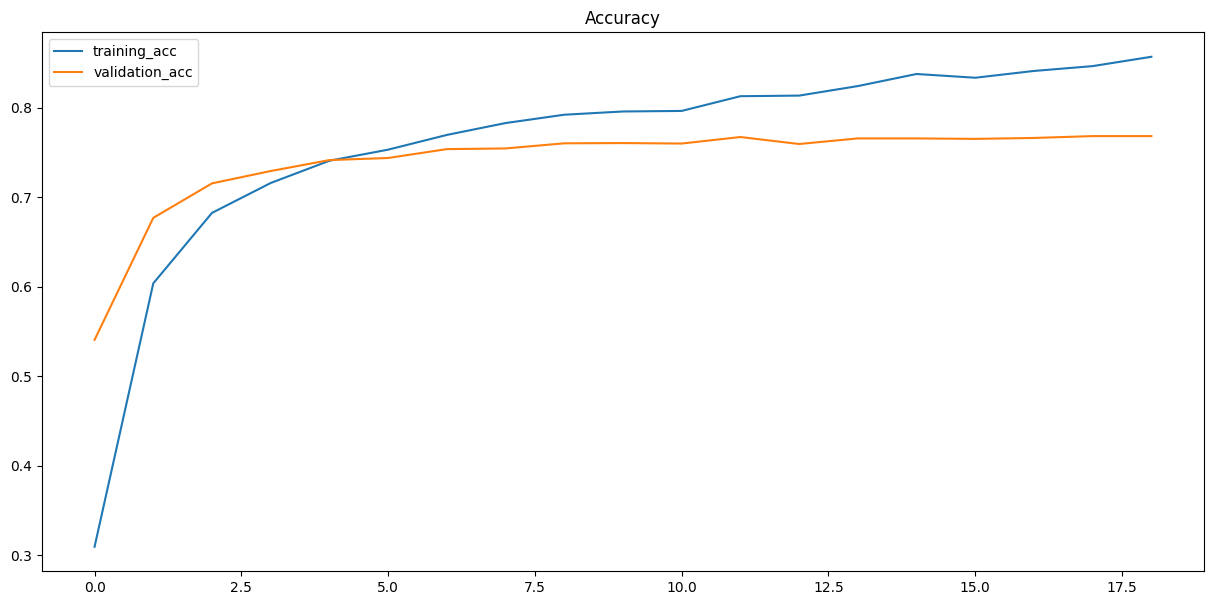

In [ ]:
plot_accuracy(bilstm_history)

In [ ]:
from keras.models import load_model
model_name = "BiLSTM1608"
best_model_path = f"{folder_path}/{model_name}_best_model.h5"
best_bilstm_model = load_model(best_model_path)

evaluate_model(best_bilstm_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, le)

Train accuracy: 83.13
Test accuracy: 75.90
8/8 [==============================] - 1s 17ms/step
Classification Report:
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.59      0.45      0.51        44
                  Huyết Học       0.65      0.73      0.68        55
                    Hóa Trị       0.50      0.21      0.29        24
       Hậu Môn - Trực Tràng       0.95      0.93      0.94       363
       Lồng Ngực - Mạch Máu       0.72      0.62      0.67       114
                        Mắt       0.96      0.90      0.93       199
                   Nam Khoa       0.78      0.79      0.79       134
             Ngoại Tim Mạch       0.68      0.72      0.70       116
            Nhi - Tiêm Ngừa       0.73      0.69      0.71       135
                   Nội Thận       0.64      0.75      0.69        56
                   Nội Tiết       0.70      0.63      0.66        92
    Phẫu Thuật Răng Hàm Mặt       0.84      0.87     

In [ ]:
y_pred_probs = best_bilstm_model.predict(X_test_pad)

# Check wrong predictions for BiLSTM model
check_wrong(y_test, y_pred_probs, le)

124/124 [==============================] - 1s 8ms/step
Text: tổ chức đám cưới đám cưới luôn xét nghiệm những chuẩn những viên sắt mang thai
Predicted: Nội Tiết - Actual: Sản - Phụ Khoa

Text: học dịch vụ xét nghiệm gen mang thai giá xét nghiệm
Predicted: Huyết Học - Actual: Sản - Phụ Khoa

Text: cái bớt màu đỏ má cao dĩ giùm
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: tuổi ung thư tuyến giáp giai đoạn hai phẫu tuần xuất số nhân luận phẫu họ đều chuyển sang khác hóa chất chuyển nhà thêm lo lắng hãy
Predicted: Nội Tiết - Actual: Hóa Trị

Text: sống huế cái bớt đỏ bẩm sinh khuôn mặt khăn tiếp xúc người khác khác nhau thông qua lời
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: giáo viên đau họng ban ít triệu đêm khuya đau rát họng ho đờm lỏng nước triệu nằm xuống ngủ tiếp tượng lặp hôm ho khạc đờm tí máu mắc thật
Predicted: Phổi - Actual: Tdcn Hô Hấp

Text: thứ tiêm vacxin mũi trung quốc tiêm tối ngủ qua đêm thứ thở đau tức ngực chút mệt trái tim m

##GRU

In [ ]:
from keras.layers import Bidirectional, GRU
gru_model = build_model((GRU(512, return_sequences=False)), vocab_len, emb_dim, y_count, embedding_matrix, learning_rate = 0.001)

In [ ]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2008200   
                                                                 
 gru (GRU)                   (None, 512)               1250304   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 28)                14364     
                                                                 
Total params: 3,272,868
Trainable params: 3,272,868
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_name = "GRU_data1608"
gru_history = train_model(gru_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, epochs, model_name)

Epoch 1/100


In [ ]:
plot_accuracy(gru_history)

In [ ]:
from keras.models import load_model
model_name = "GRU_data1608"
best_model_path = f"{folder_path}/{model_name}_best_model.h5"
best_gru_model = load_model(best_model_path)

evaluate_model(best_gru_model, X_train_pad, y_train, X_valid_pad, y_valid, batch_size, le)

Train accuracy: 87.35
Test accuracy: 77.83
16/16 [==============================] - 2s 91ms/step
Classification Report:
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.58      0.50      0.54        44
                  Huyết Học       0.71      0.85      0.78        55
                    Hóa Trị       0.67      0.17      0.27        24
       Hậu Môn - Trực Tràng       0.94      0.94      0.94       363
       Lồng Ngực - Mạch Máu       0.76      0.74      0.75       114
                        Mắt       0.90      0.90      0.90       199
                   Nam Khoa       0.81      0.78      0.80       134
             Ngoại Tim Mạch       0.75      0.75      0.75       116
            Nhi - Tiêm Ngừa       0.71      0.75      0.73       135
                   Nội Thận       0.64      0.79      0.70        56
                   Nội Tiết       0.61      0.64      0.63        92
    Phẫu Thuật Răng Hàm Mặt       0.87      0.87   

In [ ]:
y_pred_probs = best_gru_model.predict(X_test_pad)

# Check wrong predictions for GRU model
check_wrong(y_test, y_pred_probs, le)

124/124 [==============================] - 0s 3ms/step
Text: học dịch vụ xét nghiệm gen mang thai giá xét nghiệm
Predicted: Huyết Học - Actual: Sản - Phụ Khoa

Text: cái bớt màu đỏ má cao dĩ giùm
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: tuổi ung thư tuyến giáp giai đoạn hai phẫu tuần xuất số nhân luận phẫu họ đều chuyển sang khác hóa chất chuyển nhà thêm lo lắng hãy
Predicted: Nội Tiết - Actual: Hóa Trị

Text: sống huế cái bớt đỏ bẩm sinh khuôn mặt khăn tiếp xúc người khác khác nhau thông qua lời
Predicted: Thẩm Mỹ Da - Da Liễu - Actual: Tạo Hình Thẩm Mỹ

Text: giáo viên đau họng ban ít triệu đêm khuya đau rát họng ho đờm lỏng nước triệu nằm xuống ngủ tiếp tượng lặp hôm ho khạc đờm tí máu mắc thật
Predicted: Tai Mũi Họng - Actual: Tdcn Hô Hấp

Text: thứ tiêm vacxin mũi trung quốc tiêm tối ngủ qua đêm thứ thở đau tức ngực chút mệt trái tim mệt kiểu chạy vài vòng sân ấy tác dụng phụ vacxin tim
Predicted: Tim Mạch - Actual: Nhi - Tiêm Ngừa

Text: chồng bé chích ng

# 4. ML model

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
# Create a list of classifiers
classifiers = [
    #("SGD", SGDClassifier(loss = "hinge", penalty = "l2", class_weight = None)),
    #('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
    ('SVM', SVC(class_weight = None)),
    ('Logistic Regression', LogisticRegression(solver='newton-cg', max_iter=1000, class_weight = "balanced")),
    #('XGBoost', XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier(class_weight = "balanced")),
    ('Random Forest', RandomForestClassifier(class_weight = "balanced")),
]

In [ ]:
from sklearn.metrics import classification_report

import time

def evaluate_classifier(clf, X_train, y_train, X_valid, y_valid, label_encoder):
    # Measure the training start time
    train_start = time.time()

    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Measure the training end time
    train_end = time.time()

    # Calculate the training time
    train_time = train_end - train_start

    # Measure the testing start time
    test_start = time.time()

    # Make predictions on the validation data
    valid_predictions = clf.predict(X_valid)

    # Measure the testing end time
    test_end = time.time()

    # Calculate the testing time
    test_time = test_end - test_start

    # Convert the numerical labels back into text labels
    y_valid_text = label_encoder.inverse_transform(y_valid)
    valid_predictions_text = label_encoder.inverse_transform(valid_predictions)

    #print(len(y_valid_text))
    #print(len(valid_predictions_text))
    # Print the classification report with text labels
    print(classification_report(y_valid_text, valid_predictions_text))

    # Print the training and testing time
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Testing time: {test_time:.2f} seconds")

In [ ]:
y_train_ml = np.argmax(y_train, axis=1)
y_valid_ml = np.argmax(y_valid, axis=1)
y_test_ml = np.argmax(y_test, axis=1)

For word2vec

In [ ]:
for name, clf in classifiers:
    print(f"Evaluating classifier: {name}")
    evaluate_classifier(clf, X_train_w2v, Y_train, X_valid_w2v, Y_valid, le)

Evaluating classifier: SGD
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.38      0.50      0.43        44
                  Huyết Học       0.56      0.56      0.56        55
                    Hóa Trị       0.07      0.04      0.05        24
       Hậu Môn - Trực Tràng       0.91      0.92      0.92       363
       Lồng Ngực - Mạch Máu       0.60      0.44      0.51       114
                        Mắt       0.86      0.79      0.83       199
                   Nam Khoa       0.77      0.59      0.67       134
             Ngoại Tim Mạch       0.43      0.64      0.51       116
            Nhi - Tiêm Ngừa       0.53      0.64      0.58       135
                   Nội Thận       0.46      0.39      0.42        56
                   Nội Tiết       0.44      0.36      0.40        92
    Phẫu Thuật Răng Hàm Mặt       0.86      0.81      0.83       163
                       Phổi       0.89      0.82      0.85       205
      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


For TF-IDF

In [ ]:
for name, clf in classifiers:
    print(f"Evaluating classifier: {name}")

    if name == 'Linear Discriminant Analysis':
        X_train_dense = X_train_tfidf.toarray()
        X_valid_dense = X_valid_tfidf.toarray()
        evaluate_classifier(clf, X_train_dense, y_train_ml, X_valid_dense, y_valid_ml, le)
    else:
        evaluate_classifier(clf, X_train_tfidf, y_train_ml, X_valid_tfidf, y_valid_ml, le)

Evaluating classifier: SVM
                             precision    recall  f1-score   support

Dị Ứng - Miễn Dịch Lâm Sàng       0.58      0.64      0.61        44
                  Huyết Học       0.67      0.78      0.72        55
                    Hóa Trị       0.83      0.42      0.56        24
       Hậu Môn - Trực Tràng       0.91      0.93      0.92       363
       Lồng Ngực - Mạch Máu       0.84      0.68      0.75       114
                        Mắt       0.91      0.88      0.90       199
                   Nam Khoa       0.90      0.69      0.78       134
             Ngoại Tim Mạch       0.85      0.72      0.78       116
            Nhi - Tiêm Ngừa       0.65      0.70      0.68       135
                   Nội Thận       0.69      0.52      0.59        56
                   Nội Tiết       0.75      0.57      0.65        92
    Phẫu Thuật Răng Hàm Mặt       0.87      0.83      0.85       163
                       Phổi       0.87      0.84      0.85       205
      

# 5. PhoBERT model

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import openpyxl
import underthesea
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
torch.cuda.is_available()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
N_SPLITS = 6

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/data2607_Q_label.xlsx')
df.info()

In [ ]:
threshold = 60

label_counts = df['LABEL'].value_counts()
labels_to_remove = label_counts[label_counts < threshold].index
df = df[~df['LABEL'].isin(labels_to_remove)]

In [ ]:
unique_elements = df['LABEL'].unique()

# Print the unique elements with count numbers
for i, element in enumerate(unique_elements, start=0):
    print(f"{i}. {element}")

In [ ]:
df = df.dropna()
df

In [ ]:
def get_data_csv(path):
  data = pd.read_csv(path,encoding='utf-16')
  df = pd.DataFrame(data)
  df.drop(columns=['Unnamed: 0'], inplace = True)
  return df

In [ ]:
def get_json_data(path):
  data = pd.read_json(path)
  df = pd.DataFrame(data)
  df.drop(columns=['seq_label'], inplace = True)
  return df

In [ ]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(data=df, y='LABEL', width=0.8)
plt.show()

In [ ]:
X = df['Q1']
y = df['LABEL'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_df = pd.DataFrame({'Q1': X_train, 'LABEL': y_train})
test_df = pd.DataFrame({'Q1': X_test, 'LABEL': y_test})

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# We will use Kfold later
train_df = pd.concat([train_df, test_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.LABEL)):
    train_df.loc[val_, "kfold"] = fold

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
tokenizer

In [ ]:
def get_input_data(self, row):
    # Preprocessing: {remove icon, special character, lower}
    text = row['Q1']
    text = ' '.join(simple_preprocess(text))
    label = self.labelencoder(row['LABEL'])

    # Handle unknown labels
    if label is None:
        raise ValueError(f"Unknown label: {row['LABEL']}")

    return text, label

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=500):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Dị ứng - Miễn dịch lâm sàng':
            return 0
        elif text=='Tiêu hóa - Gan mật':
            return 1
        elif text=='Thẩm mỹ da - Da liễu':
            return 2
        elif text=='Tai Mũi Họng':
            return 3
        elif text=='Nhi - Tiêm ngừa':
            return 4
        elif text=='Hậu môn - Trực tràng':
            return 5
        elif text=='Lồng ngực - Mạch máu':
            return 6
        elif text=='Xương khớp':
            return 7
        elif text=='Tạo hình Thẩm mỹ':
            return 8
        elif text=='Tim mạch':
            return 9
        elif text=='Tiết niệu':
            return 10
        elif text=='Tổng quát - Y học gia đình':
            return 11
        elif text=='Thần Kinh':
            return 12
        elif text=='Phổi':
            return 13
        elif text=='Viêm gan':
            return 14
        elif text=='Mắt':
            return 15
        elif text=='Nội Tiết':
            return 16
        elif text=='Nam Khoa':
            return 17
        elif text=='Sản - Phụ Khoa':
            return 18
        elif text=='Vú - FNA':
            return 19
        elif text=='Phẫu thuật răng hàm mặt':
            return 20
        elif text=='Ngoại tim mạch':
            return 21
        elif text=='Sức khỏe':
            return 22
        elif text== 'TDCN Hô hấp':
            return 23
        elif text== 'Vấn đề khác':
            return 24

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Q1']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['LABEL'])
        # Handle unknown labels
        if label is None:
          raise ValueError(f"Unknown label: {row['LABEL']}")

        return text, label

In [ ]:
# Distribution of length of Sentence
all_data = train_df.Q1.tolist() + test_df.Q1.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [ ]:
class DepartmentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(DepartmentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base", from_tf=False)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
import argparse
import sys

# Define the load_args() function to parse command-line arguments
def load_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--gradient_accumulation_steps', default=1, type=int)

    if 'ipykernel_launcher' in sys.argv[0]:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

args = load_args()

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for batch_idx, data in enumerate(train_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()

        if (batch_idx + 1) % args.gradient_accumulation_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df, fold, batch_size):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return train_loader, valid_loader


batch_size = 16
gradient_accumulation_steps = args.gradient_accumulation_steps

In [ ]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold, batch_size=batch_size)
    model = DepartmentClassifier(n_classes=25).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * EPOCHS // gradient_accumulation_steps
    )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-' * 30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = DepartmentClassifier(n_classes=25)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

In [ ]:
class_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(30):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Q1)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

In [ ]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [ ]:
infer('cô ấy muốn làm phẫu thuật thẩm mỹ ', tokenizer)

In [ ]:
test_dataset